In [1]:
from matplotlib.pyplot import *
import numpy as np
import h5py
from Data_Core.experiment import *
from Data_Core.digital_twin import *
from tqdm import tqdm
from src.algorithms import *
import torch
import sklearn
from scipy.spatial.distance import *
%load_ext autoreload

In [2]:
find_index = lambda wavelenghts, w : np.argmin(np.abs(wavelenghts - w))

In [3]:
def Raman_data_loader(filename):

    with h5py.File(filename, 'a') as output_file:
         
        properties = output_file['properties']
        
        exp_properties = {'step_size' : np.array(properties['step_size'])[0],
                          'speed' : np.array(properties['speed']),
                          'n_points' : np.array(properties['n_points'])
            }
        
        wavelengths = np.array(output_file['properties']['x_data'])
        
        
        spot_numbers = [int(s.split('_')[-1]) for s in list(output_file['data'].keys()) if 'spot' in s ]
        
        Nx,Ny = output_file['properties']['n_points'][0], output_file['properties']['n_points'][1]
        Nl = len(wavelengths)
        spectral_signal = np.zeros([Nx,Ny,Nl])
        
        
        for _i, spot_number in enumerate(spot_numbers):

            ix, iy = int(spot_number//Ny), int(spot_number%Ny)
            
            spot = 'spot_'+str(spot_number)
            data = np.array(output_file['data'][spot]['raw_data'])
                      
            spectral_signal[ix,iy,:] = data
            

    return spectral_signal, wavelengths, exp_properties

In [4]:
filename = "2023913_1110.h5"
# filename = "2023811_1451.h5"
spectrum_raman, wavelengths_raman, exp_properties = Raman_data_loader(filename)

In [5]:
from scipy import sparse
from scipy.sparse.linalg import spsolve

def baseline_als_optimized(y, lam, p, niter = 10):
    L = len(y)
    D = sparse.diags([1, -2, 1],[0, -1, -2], shape = (L, L - 2))
    D = lam * D.dot(D.transpose()) # Precompute this term since it does not depend on `w`
    w = np.ones(L)
    W = sparse.spdiags(w, 0, L, L)
    for i in range(niter):
        W.setdiag(w) # Do not create a new matrix, just update diagonal values
        Z = W + D
        z = spsolve(Z, w*y)
        w = p * (y > z) + (1 - p) * (y < z)
    return z

In [6]:
lam = 1e2
p = 1e-1

pro_data = 1*spectrum_raman
for i in tqdm(range(0, pro_data.shape[0])):
    for j in range(0, pro_data.shape[1]):
        # print(i,j,end='\r')
        spec = 1 * pro_data[i, j, :]
        pro_data[i, j, :] = spec - baseline_als_optimized(spec, lam = lam, p = p, niter = 10)

100%|██████████| 250/250 [09:58<00:00,  2.39s/it]


In [7]:
offset_l = 31
offset_m = 328

mask = pro_data[:, :, offset_l:offset_m].reshape(pro_data.shape[0]*pro_data.shape[1], -1)

# threshold = 120
# threshold2 = 0.01

# # Scaled to max value for each wavenumber
# # masks = np.array([mask[:, i]*(mask[:, i] > threshold)/np.max(mask[:, i]) for i in range(mask.shape[-1])])
# masks = np.array([np.array((mask[:, i]/np.max(mask[:, i]))*((mask[:, i] > threshold)) > threshold2, dtype = int) for i in range(mask.shape[-1])])

In [8]:
init_k = np.array([[0], [1]])

In [9]:
threshold = 150

mask_offset = np.array(mask)
mask_t = np.array([(mask_offset[:, i])*((mask_offset[:, i] > threshold)) for i in range(mask_offset.shape[-1])])

In [343]:
# from scipy.ndimage import gaussian_filter
# mask_min_max = np.array([(mask_t[i, :] - mask_t[i, :].min(axis = 0))/(mask_t[i, :].max(axis = 0) - mask_t[i, :].min(axis = 0) + 1e-5) for i in range(mask_t.shape[0])])
# mask_min_max = np.array([(mask_t[i, :])/(mask_t[i, :].max(axis = 0) + 1e-10) for i in range(mask_t.shape[0])])
# masks1 = np.array([sklearn.cluster.KMeans(n_clusters = 2, init = init_k, random_state = 100).fit_predict(mask_min_max[i, :].reshape(-1, 1)) for i in range(mask_min_max.shape[0])])
# masks1 = masks1.T.reshape(pro_data.shape[0], pro_data.shape[1], -1)
# masks = np.array([gaussian_filter(masks1[:, :, i], sigma = 0.15) for i in range(masks1.shape[-1])]).reshape(297, pro_data.shape[0]*pro_data.shape[1])

c:\Users\tomas\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:984: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
c:\Users\tomas\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:984: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
c:\Users\tomas\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:984: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
c:\Users\tomas\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:984: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
c:\Users\tomas\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:984: RuntimeWarning: Explicit initial center position passed: performing only 

In [18]:
from scipy.signal import savgol_filter
mask_t1 = np.array([savgol_filter(mask_t[:, i], window_length = 3, polyorder = 1, mode = 'nearest') for i in range(mask_t.shape[-1])]).T
mask_min_max = np.array([(mask_t1[i, :] - mask_t1[i, :].min(axis = 0))/(mask_t1[i, :].max(axis = 0) - mask_t1[i, :].min(axis = 0) + 1e-5) for i in range(mask_t1.shape[0])])
masks = np.array([sklearn.cluster.KMeans(n_clusters = 2, init = init_k, random_state = 100).fit_predict(mask_min_max[i, :].reshape(-1, 1)) for i in range(mask_min_max.shape[0])])

c:\Users\tomas\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:984: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
c:\Users\tomas\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:984: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
c:\Users\tomas\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:984: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
c:\Users\tomas\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:984: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
c:\Users\tomas\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:984: RuntimeWarning: Explicit initial center position passed: performing only 

In [11]:
def read_ref(mineral):
    df = pd.read_csv(mineral + '_raman.txt',header=13,names=['wavenumber','int'],skipfooter=4,engine='python' )
    return np.array(df['wavenumber']),np.array(df['int'])

Albite
Background
Background not found
Petalite
Quartz
Spodumene


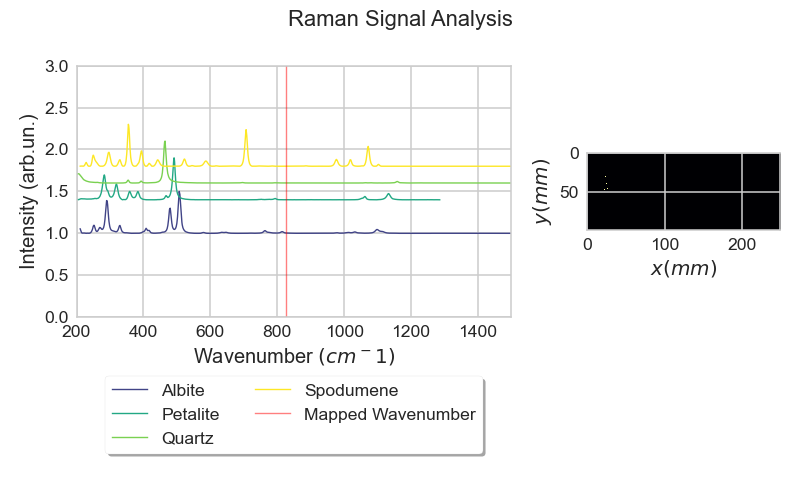

In [19]:

fig, ax = subplots(1, 2, figsize = (8, 5), gridspec_kw = {'width_ratios': [0.9, 0.4]})
fig.suptitle('Raman Signal Analysis')

axs = ax[0]
minerals = {
    
    'Albite':[508.1],
    'Background':[733.1],
    'Petalite':[491.3],
    'Quartz':[463.92],
    'Spodumene':[704.5]}

mineral_list = list(minerals.keys())
for i,mineral in enumerate(mineral_list):
    print(mineral)
    try:
        wl,spec = read_ref(mineral)
        axs.plot(wl, 1 + 0.2*i + 0.5 * spec/np.max(spec), lw = 1, color = cm.viridis((i+1)/len(mineral_list)), label = mineral)
    except:
        print(mineral + ' not found')
axs.set_ylim(0,1+0.2*(i+1)+1)
axs.set_xlim(200,1500)
    
axs.legend(loc = 'upper right', bbox_to_anchor = (1.0, 1.0), ncol = 2, fancybox = True, shadow = True)
wn = 120
line = axs.axvline(wavelengths_raman[offset_l:offset_m][wn], lw = '1', alpha = 0.5, color = 'red', label = 'Mapped Wavenumber')
axs.set_xlabel(r'Wavenumber $(cm^-1)$')
axs.set_ylabel(r'Intensity (arb.un.)')
axs.legend(loc='upper center', bbox_to_anchor = (0.5, -0.2), ncol = 2, fancybox = True, shadow = True)

axs = ax[1]
axs.imshow(masks.T.reshape(pro_data.shape[0], pro_data.shape[1], -1)[:, :, wn].T, cmap = cm.inferno, interpolation = 'none')
axs.set_xlabel(r'$x(mm)$')
axs.set_ylabel(r'$y(mm)$')


def update_map(wn):
    im = ax[1].imshow(masks.T.reshape(pro_data.shape[0], pro_data.shape[1], -1)[:, :, wn].T, cmap = cm.inferno, interpolation = 'none')
    line.set_xdata(wavelengths_raman[offset_l:offset_m][wn])

def onclick(event):
    ix, iy = event.xdata, event.ydata
    wn = find_index(wavelengths_raman[offset_l:offset_m], ix)
    if event.inaxes == ax[0] or ax0:
        update_map(wn)
        fig.canvas.draw_idle()
        
cid = fig.canvas.mpl_connect('button_press_event', onclick)
fig.tight_layout()

In [20]:
pytorch_masks = torch.from_numpy(masks)

In [21]:
init_maps = torch.tensor([masks[find_index(wavelengths_raman[offset_l:offset_m], 509)], 
                 np.zeros(25000), 
                 masks[find_index(wavelengths_raman[offset_l:offset_m], 490)], 
                 masks[find_index(wavelengths_raman[offset_l:offset_m], 705)], 
                 np.zeros(25000), 
                 np.zeros(25000)])

In [31]:
%autoreload
kmeans = torch_Kmeans(num_clusters = 6, distance = 'hamming', device = torch.device('cuda'))
kmeans.fit(pytorch_masks)
# kmeans = sklearn.cluster.KMeans(n_clusters = 6, init = init_maps)
# kmeans.fit_predict(masks)

Running Kmeans on cuda..


[Running Kmeans]: 15it [00:00, 28.67it/s, center_shift=0.000000, iteration=15, tol=0.000100]   


In [32]:
labels = kmeans.labels_.cpu()
# labels = kmeans.labels_

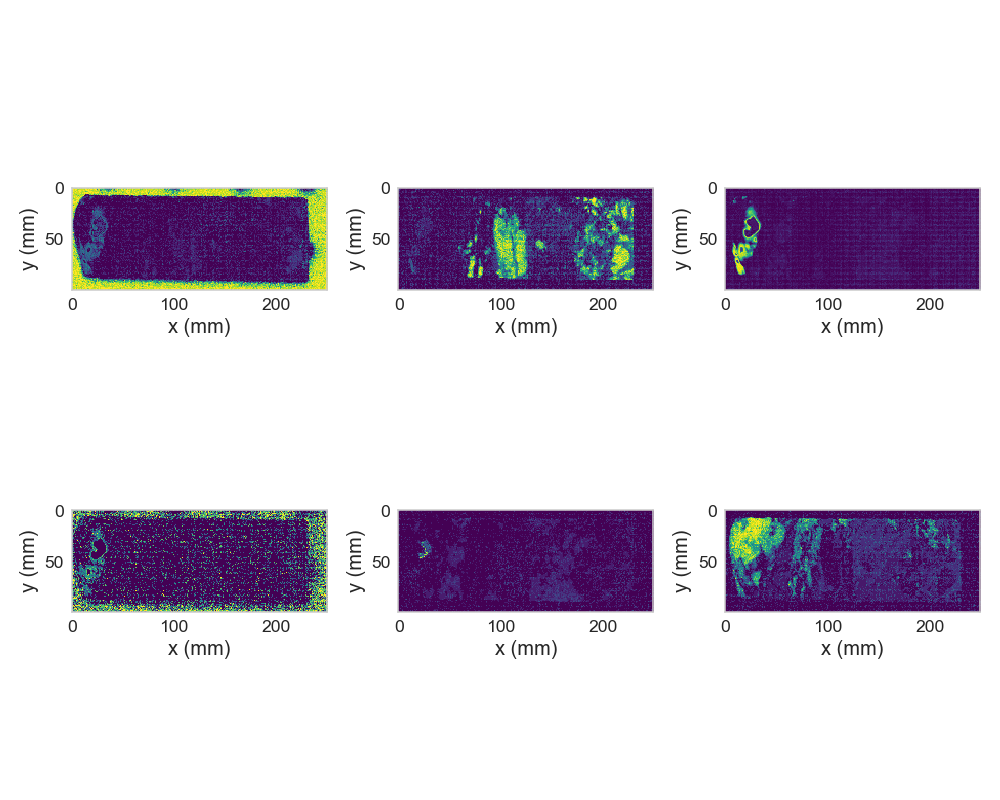

In [33]:
fig, ax = subplots(2, 3, figsize = (10, 8))
clusters_c = np.array(kmeans.cluster_centers_.cpu())
# clusters_c = np.array(kmeans.cluster_centers_)

j = 0
l = 0

for i in range(len(np.unique(labels))):
    axs = ax[l, j]
    # axs.imshow(clusters_c[i].reshape(pro_data.shape[:2]).T, interpolation = 'none')
    axs.imshow(clusters_c[i].reshape(pro_data.shape[0], pro_data.shape[1]).T, interpolation = 'none')
    axs.set_ylabel('y (mm)')
    axs.set_xlabel('x (mm)')
    axs.grid(False)
    j += 1
    if j == 3:
        j = 0
        l += 1

fig.tight_layout()

Albite
Background
Background not found
Petalite
Quartz
Spodumene


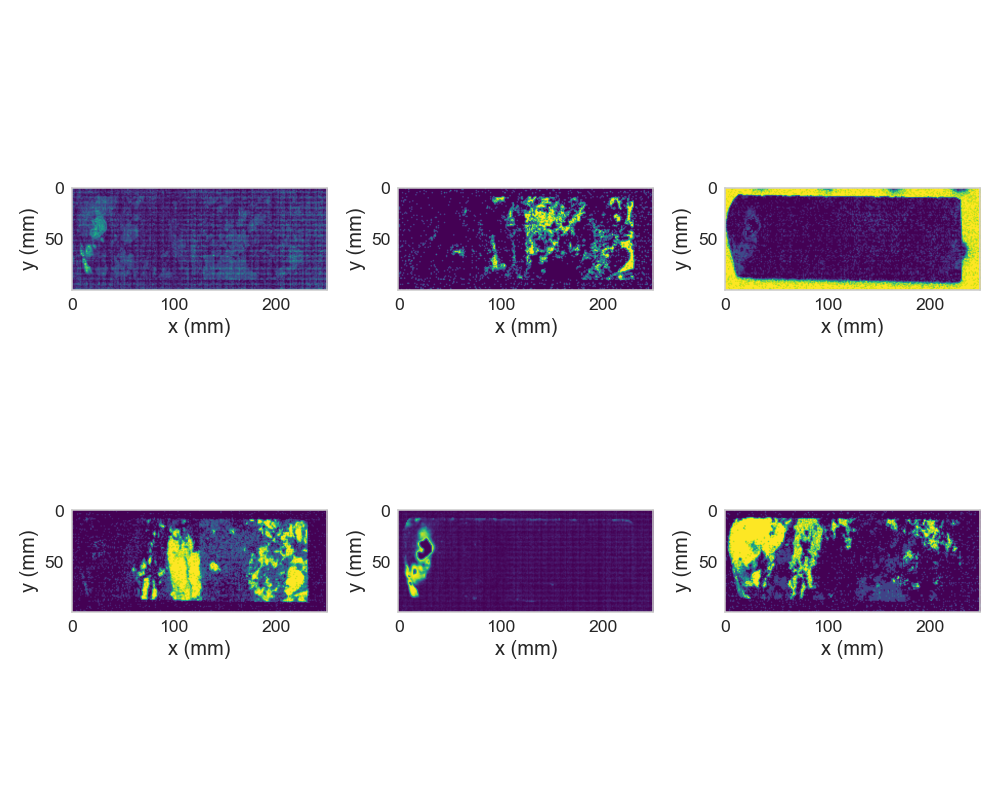

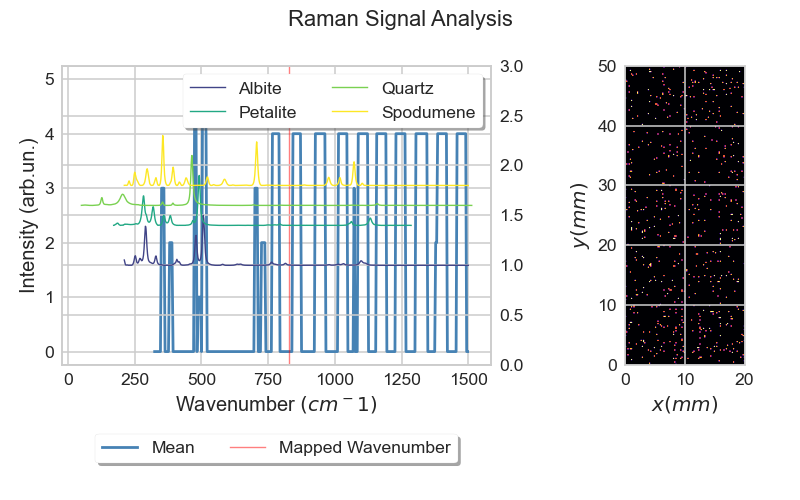

In [79]:
%matplotlib widget

fig, ax = subplots(2, 3, figsize = (10, 8))
# clusters_c = np.array(kmeans.cluster_centers_.cpu())

j = 0
l = 0

for i in range(len(np.unique(labels))):
    axs = ax[l, j]
    axs.imshow(clusters_c[i].reshape(pro_data.shape[:2]).T, interpolation = 'gaussian')
    axs.set_ylabel('y (mm)')
    axs.set_xlabel('x (mm)')
    axs.grid(False)
    j += 1
    if j == 3:
        j = 0
        l += 1

fig.tight_layout()

fig, ax = subplots(1, 2, figsize = (8, 5), gridspec_kw = {'width_ratios': [0.9, 0.4]})
fig.suptitle('Raman Signal Analysis')

axs = ax[0]
axs.plot(wavelengths_raman[offset_l:offset_m], labels, lw = 2, ls = '-', color = 'steelblue', label = 'Mean')
wn = 120
line = axs.axvline(wavelengths_raman[offset_l:offset_m][wn], lw = '1', alpha = 0.5, color = 'red', label = 'Mapped Wavenumber')
axs.set_xlabel(r'Wavenumber $(cm^-1)$')
axs.set_ylabel(r'Intensity (arb.un.)')
axs.legend(loc='upper center', bbox_to_anchor = (0.5, -0.2), ncol = 2, fancybox = True, shadow = True)

ax0 = ax[0].twinx()

minerals = {
    
    'Albite':[508.1],
    'Background':[733.1],
    'Petalite':[491.3],
    'Quartz':[463.92],
    'Spodumene':[704.5]}

mineral_list = list(minerals.keys())
for i,mineral in enumerate(mineral_list):
    print(mineral)
    try:
        wl,spec = read_ref(mineral)
        ax0.plot(wl, 1 + 0.2*i + 0.5 * spec/np.max(spec), lw = 1, color = cm.viridis((i+1)/len(mineral_list)), label = mineral)
    except:
        print(mineral + ' not found')
ax0.set_ylim(0,1+0.2*(i+1)+1)
# ax0.set_xlim(200,1500)
    
ax0.legend(loc = 'upper right', bbox_to_anchor = (1.0, 1.0), ncol = 2, fancybox = True, shadow = True)
sca(ax[0])

axs = ax[1]
axs.imshow(masks.T.reshape(pro_data.shape[0], pro_data.shape[1], -1)[:, :, wn], cmap = cm.inferno, extent = [0, exp_properties['step_size']*exp_properties['n_points'][1],
                                                        0, exp_properties['step_size']*exp_properties['n_points'][0]])
axs.set_xlabel(r'$x(mm)$')
axs.set_ylabel(r'$y(mm)$')


def update_map(wn):
    im = ax[1].imshow(masks.T.reshape(pro_data.shape[0], pro_data.shape[1], -1)[:, :, wn], cmap = cm.inferno,
                      extent = [0, exp_properties['step_size']*exp_properties['n_points'][1],
                            0, exp_properties['step_size']*exp_properties['n_points'][0]],
                     interpolation = 'none')
    line.set_xdata(wavelengths_raman[offset_l:offset_m][wn])

def onclick(event):
    ix, iy = event.xdata, event.ydata
    wn = find_index(wavelengths_raman[offset_l:offset_m], ix)
    if event.inaxes == ax[0] or ax0:
        update_map(wn)
        fig.canvas.draw_idle()
        
cid = fig.canvas.mpl_connect('button_press_event', onclick)
fig.tight_layout()

In [141]:
x = torch.tensor([[1, 1, 0], [0, 0, 1], [1, 1, 1], [1, 0, 0]])
y = torch.tensor([1, 0, 0])

A = x.unsqueeze(dim = 1)

        # 1*N*M
B = y.unsqueeze(dim = 0)

inter = torch.sum(torch.tensor(A == B, dtype = int), dim = 2)
metric = (B.shape[1] - inter)/B.shape[1]
# metric = (y.size()[0] - torch.sum(torch.tensor(x == y, dtype = int)))/(y.size()[0])

c:\Users\tomas\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':
